# Week 6 Lab: Unsupervised Learning

This week's assignment will focus completeing a K-Means analysis.

## Our Dataset: 
**Dataset:** wine_fraud.csv(Provided in folder assign_wk6)

Remember to take a look at the wine.names files for a better understanding of the dataset. You can also read more about the dataset [here](https://archive.ics.uci.edu/ml/datasets/wine).


## Unsupervised Learning

**Objective:** 
   - Use K-Means for this analysis: State and defend all your assumptions about the dataset. Defend yourself!!!
       * Make sure you cleanup your data, including the readability of your dataset
       * EDA!!!  Explore your data!
       * Categorical vs numeric columns in your dataset
       * Would normalizing your dataset help? 
   - Cluster the wines to see if there are some natural groupings
   - Use PCA to plot the clusters
   - Discover any insights from this analysis? (include numbers/graphs corresponding to your reasoning)
       * Summarize your findings.
       * What does the PCA plot tell you about your clustering?


## I. Introduction

This weeks analysis is on a dataset with bank customer details, marketing campaign interactions and responses, other details about marketing, social/economic context, and our output as to whether a specific client has subscribed to term deposit.

The datasets for this week are provided in bank-additional-full.csv and is describe in Attribute Information.

## II. Methods/Code, III. Results/Output, IV. Analysis of Results

### Setup
---

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy import stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pylab as plt
import seaborn as sns
import phik

In [2]:
!head assign_wk6/wine_fraud.csv

In [3]:
!head assign_wk6/wine.names

1. Title of Database: Wine recognition data
	Updated Sept 21, 1998 by C.Blake : Added attribute information

2. Sources:
   (a) Forina, M. et al, PARVUS - An Extendible Package for Data
       Exploration, Classification and Correlation. Institute of Pharmaceutical
       and Food Analysis and Technologies, Via Brigata Salerno, 
       16147 Genoa, Italy.

   (b) Stefan Aeberhard, email: stefan@coral.cs.jcu.edu.au


In [4]:
wine_df = pd.read_csv('assign_wk6/wine_fraud.csv')
wine_df

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


- **Categorical vs numeric columns in your dataset**

In [41]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   v0      178 non-null    int64  
 1   v1      178 non-null    float64
 2   v2      178 non-null    float64
 3   v3      178 non-null    float64
 4   v4      178 non-null    float64
 5   v5      178 non-null    int64  
 6   v6      178 non-null    float64
 7   v7      178 non-null    float64
 8   v8      178 non-null    float64
 9   v9      178 non-null    float64
 10  v10     178 non-null    float64
 11  v11     178 non-null    float64
 12  v12     178 non-null    float64
 13  v13     178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


It looks like we have no missing values, all values are non-null, and everything is already numeric. Cleanup for us will be checking to see if we can improve the readability of our column names, and see if there are any major outliers. **However**, our v0 column only has the values 1, 2, and 3 and is likely an encoded categorical column.

### Data Cleanup
***

The columns readable names were available when digging into the associated text file wine.names, and I have created a mapping dictionary below for easier analysis.

In [5]:
col_mapper = {'v0':'class_id', 'v1':'alcohol', 'v2':'malic_acid', 'v3':'ash', 'v4':'alcalinity_of_ash', 
              'v5':'magnesium', 'v6':'total_phenols', 'v7':'flavanoids', 'v8':'nonflavanoid_phenols', 
              'v9':'proanthocyanins', 'v10':'color_intensity', 'v11':'hue', 
              'v12':'OD280_OD315_of_diluted_wines', 'v13':'proline'}

readable_wine_df = wine_df.rename(columns=col_mapper)
readable_wine_df

,class_id,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,OD280_OD315_of_diluted_wines,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [6]:
readable_wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   class_id                      178 non-null    int64  
 1   alcohol                       178 non-null    float64
 2   malic_acid                    178 non-null    float64
 3   ash                           178 non-null    float64
 4   alcalinity_of_ash             178 non-null    float64
 5   magnesium                     178 non-null    int64  
 6   total_phenols                 178 non-null    float64
 7   flavanoids                    178 non-null    float64
 8   nonflavanoid_phenols          178 non-null    float64
 9   proanthocyanins               178 non-null    float64
 10  color_intensity               178 non-null    float64
 11  hue                           178 non-null    float64
 12  OD280_OD315_of_diluted_wines  178 non-null    float64
 13  proli

In [7]:
readable_wine_df.describe()

,class_id,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,OD280_OD315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


<AxesSubplot:ylabel='class_id'>

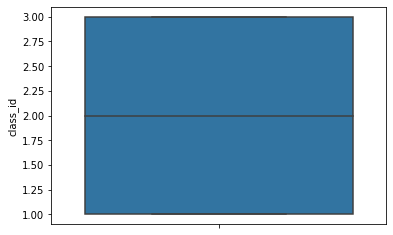

In [50]:
sns.boxplot(y=readable_wine_df['class_id'])

<AxesSubplot:ylabel='alcohol'>

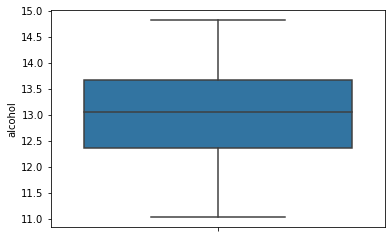

In [51]:
sns.boxplot(y=readable_wine_df['alcohol'])

<AxesSubplot:ylabel='malic_acid'>

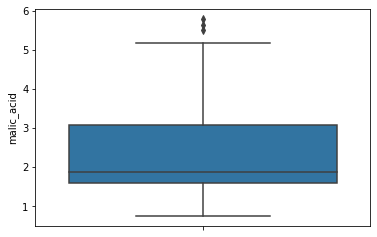

In [52]:
sns.boxplot(y=readable_wine_df['malic_acid'])

<AxesSubplot:ylabel='ash'>

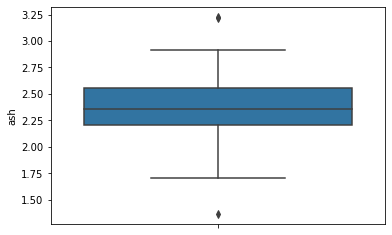

In [53]:
sns.boxplot(y=readable_wine_df['ash'])

<AxesSubplot:ylabel='alcalinity_of_ash'>

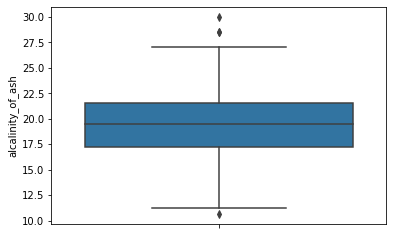

In [54]:
sns.boxplot(y=readable_wine_df['alcalinity_of_ash'])

<AxesSubplot:ylabel='magnesium'>

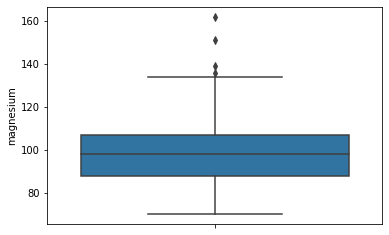

In [55]:
sns.boxplot(y=readable_wine_df['magnesium'])

<AxesSubplot:ylabel='total_phenols'>

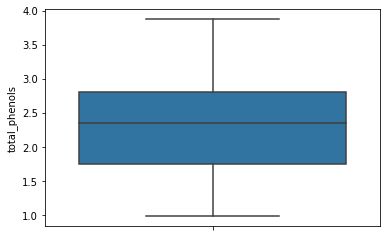

In [56]:
sns.boxplot(y=readable_wine_df['total_phenols'])

<AxesSubplot:ylabel='flavanoids'>

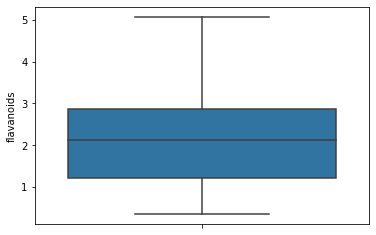

In [57]:
sns.boxplot(y=readable_wine_df['flavanoids'])

<AxesSubplot:ylabel='nonflavanoid_phenols'>

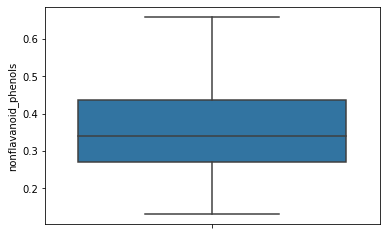

In [58]:
sns.boxplot(y=readable_wine_df['nonflavanoid_phenols'])

<AxesSubplot:ylabel='proanthocyanins'>

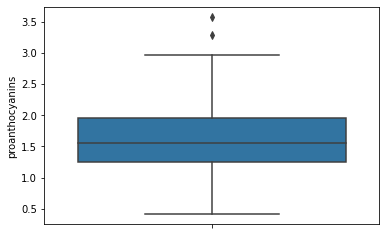

In [59]:
sns.boxplot(y=readable_wine_df['proanthocyanins'])

<AxesSubplot:ylabel='color_intensity'>

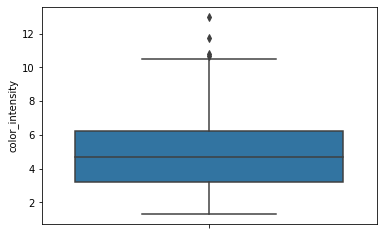

In [60]:
sns.boxplot(y=readable_wine_df['color_intensity'])

<AxesSubplot:ylabel='hue'>

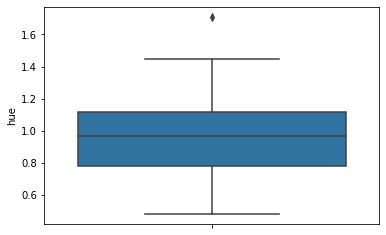

In [61]:
sns.boxplot(y=readable_wine_df['hue'])

<AxesSubplot:ylabel='OD280_OD315_of_diluted_wines'>

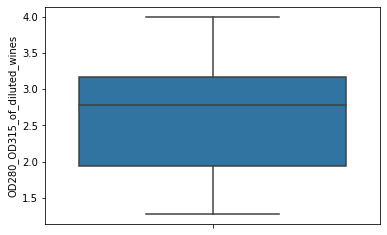

In [62]:
sns.boxplot(y=readable_wine_df['OD280_OD315_of_diluted_wines'])

<AxesSubplot:ylabel='proline'>

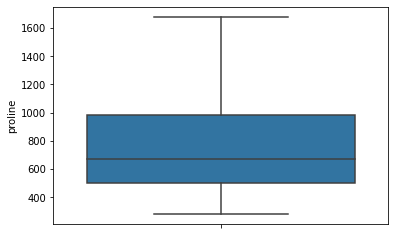

In [63]:
sns.boxplot(y=readable_wine_df['proline'])

We do have some outliers, and the question in our data preparation is whether we should drop them from our analysis or not. I think that since we are doing unsupervised classification on this dataset, and outliers might be a useful signal for anomaly detection that we should leave them in. We can always go back and try the analysis with the outliers removed if there is some reason to do so.

### EDA and Data Preparation
***

The first part of our data cleanup will be to handle the missing values, which are being categorized as unknown for some of our categorical variables. My rationale is that if the column is not correlated to our output column 'y' then we can delete it, however if it is we should determine an imputation strategy.

2    71
1    59
3    48
Name: class_id, dtype: int64

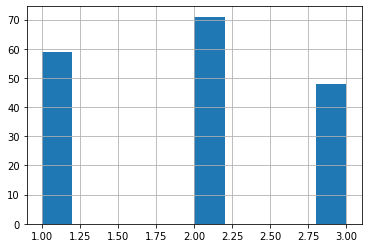

In [8]:
readable_wine_df['class_id'].hist()
readable_wine_df['class_id'].value_counts()

<AxesSubplot:ylabel='alcohol'>

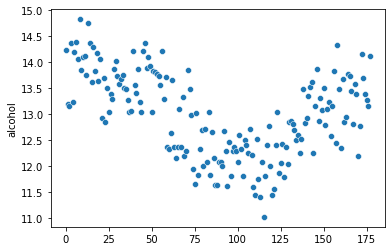

In [9]:
sns.scatterplot(data=readable_wine_df['alcohol'])

<AxesSubplot:ylabel='malic_acid'>

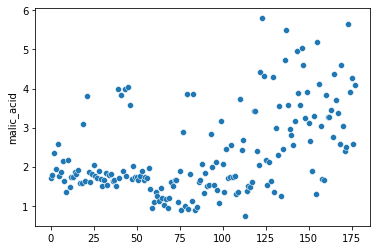

In [10]:
sns.scatterplot(data=readable_wine_df['malic_acid'])

<AxesSubplot:ylabel='ash'>

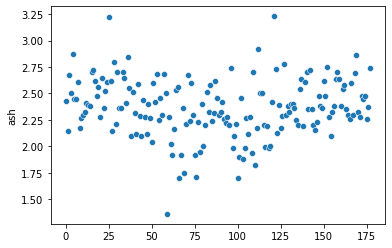

In [11]:
sns.scatterplot(data=readable_wine_df['ash'])

<AxesSubplot:ylabel='alcalinity_of_ash'>

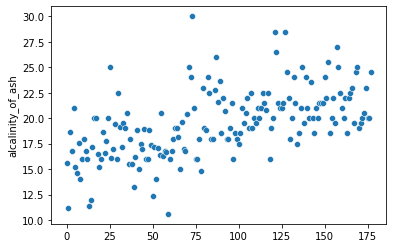

In [12]:
sns.scatterplot(data=readable_wine_df['alcalinity_of_ash'])

<AxesSubplot:ylabel='magnesium'>

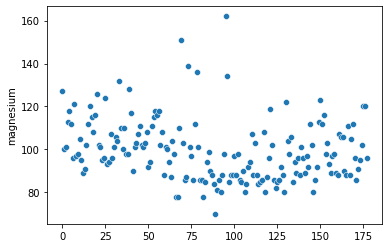

In [13]:
sns.scatterplot(data=readable_wine_df['magnesium'])

<AxesSubplot:ylabel='total_phenols'>

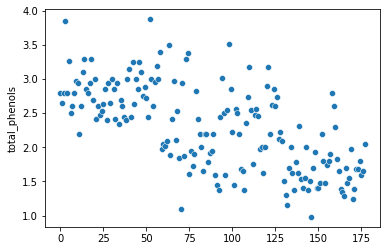

In [14]:
sns.scatterplot(data=readable_wine_df['total_phenols'])

<AxesSubplot:ylabel='flavanoids'>

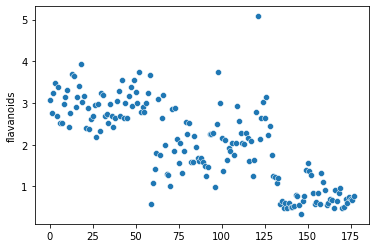

In [15]:
sns.scatterplot(data=readable_wine_df['flavanoids'])

<AxesSubplot:ylabel='nonflavanoid_phenols'>

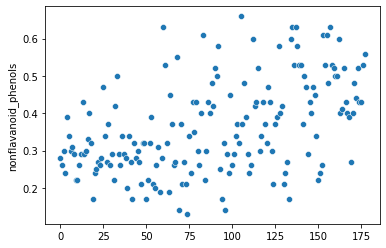

In [16]:
sns.scatterplot(data=readable_wine_df['nonflavanoid_phenols'])

<AxesSubplot:ylabel='proanthocyanins'>

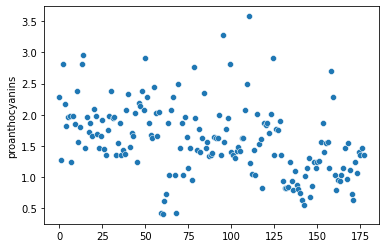

In [17]:
sns.scatterplot(data=readable_wine_df['proanthocyanins'])

<AxesSubplot:ylabel='color_intensity'>

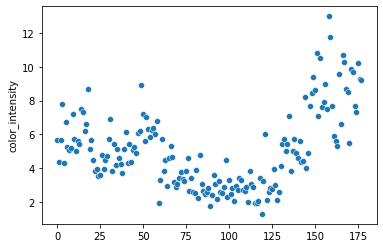

In [18]:
sns.scatterplot(data=readable_wine_df['color_intensity'])

<AxesSubplot:ylabel='hue'>

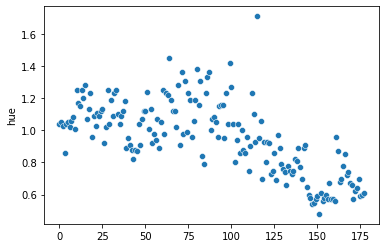

In [19]:
sns.scatterplot(data=readable_wine_df['hue'])

<AxesSubplot:ylabel='OD280_OD315_of_diluted_wines'>

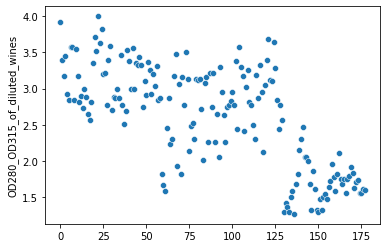

In [20]:
sns.scatterplot(data=readable_wine_df['OD280_OD315_of_diluted_wines'])

<AxesSubplot:ylabel='proline'>

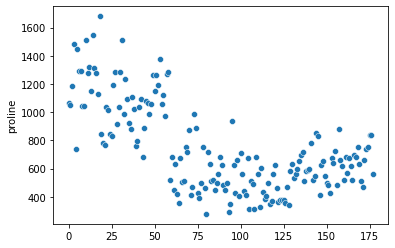

In [21]:
sns.scatterplot(data=readable_wine_df['proline'])

<AxesSubplot:xlabel='alcohol', ylabel='malic_acid'>

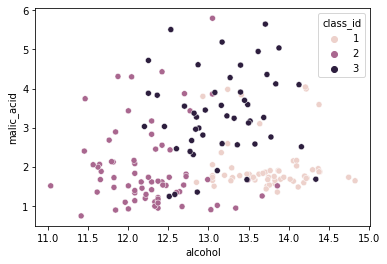

In [22]:
sns.scatterplot(x=readable_wine_df['alcohol'], y=readable_wine_df['malic_acid'], hue=readable_wine_df['class_id'])

<AxesSubplot:xlabel='OD280_OD315_of_diluted_wines', ylabel='proline'>

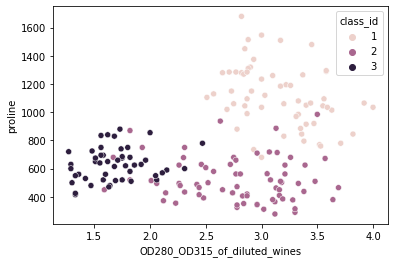

In [23]:
sns.scatterplot(x=readable_wine_df['OD280_OD315_of_diluted_wines'], 
                y=readable_wine_df['proline'], 
                hue=readable_wine_df['class_id'])

<AxesSubplot:xlabel='OD280_OD315_of_diluted_wines', ylabel='color_intensity'>

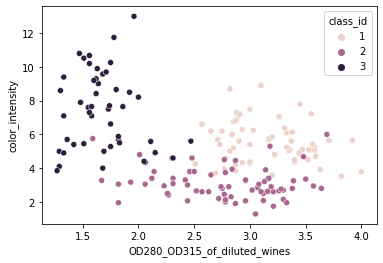

In [24]:
sns.scatterplot(x=readable_wine_df['OD280_OD315_of_diluted_wines'], 
                y=readable_wine_df['color_intensity'], 
                hue=readable_wine_df['class_id'])

We can see how we might slice these into classes with how it was done with the dataset.

It is fair to assume here that our v0, class_id column is a categorical column for splitting up this dataset into some clusters. We will want to drop it from our dataset before doing the unsupervised learning so that it does not leak into our result.

In [25]:
# Adapted from https://worldclass.regis.edu/d2l/le/content/285076/viewContent/4152309/View
# split data into features (X) and labels (y)
X = readable_wine_df.iloc[:,1:14]

# We won't really use the class_id column but I will compare it to what we come up with at the end
# even though we are not specifically trying to predict the class_id label or anything
y = readable_wine_df.iloc[:,0]

- **Would normalizing your dataset help?**

We need to normalize our data because the K-Means algorithm is not scale-invariant. I have chosen to use the min-max scaler as a change of pace from the standard scaler, but they could easily be replace and ran using a different normalization method.

In [26]:
# Normalized using the min-max scaler

X = pd.DataFrame(MinMaxScaler().fit_transform(X))

### Part 1: K-Means Analysis
***

- **Cluster the wines to see if there are some natural groupings**

We will start our K-Means Clustering and Analysis by first finding our optimal K-value.

In [27]:
# Adapted from https://worldclass.regis.edu/d2l/le/content/285076/viewContent/4152309/View
# Using within sum of squares to determine the optimal number of clusters for the final model. 

# determine the optimal number of clusters 
sum_sq= []

# fit the model for a range of 2 to 30 clusters and add to sum_sq[]
for n in range (2,30):
    print('Calculating for ',n,' clusters')
    
    # random_start makes the results reproducible 
    # n_jobs=-1 means run with all machine processors
    model = KMeans(n_clusters=n, random_state=42)
    model.fit(X)
    sum_sq.append(-model.score(X))

Calculating for  2  clusters
Calculating for  3  clusters
Calculating for  4  clusters
Calculating for  5  clusters
Calculating for  6  clusters
Calculating for  7  clusters
Calculating for  8  clusters
Calculating for  9  clusters
Calculating for  10  clusters
Calculating for  11  clusters
Calculating for  12  clusters
Calculating for  13  clusters
Calculating for  14  clusters
Calculating for  15  clusters
Calculating for  16  clusters
Calculating for  17  clusters
Calculating for  18  clusters
Calculating for  19  clusters
Calculating for  20  clusters
Calculating for  21  clusters
Calculating for  22  clusters
Calculating for  23  clusters
Calculating for  24  clusters
Calculating for  25  clusters
Calculating for  26  clusters
Calculating for  27  clusters
Calculating for  28  clusters
Calculating for  29  clusters


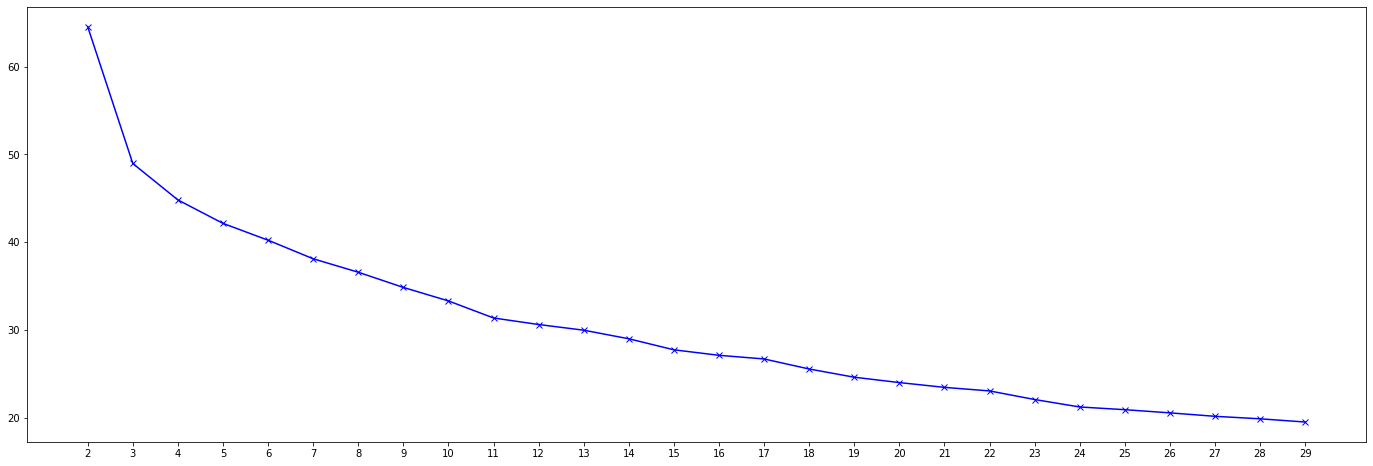

In [28]:
# Adapted from https://worldclass.regis.edu/d2l/le/content/285076/viewContent/4152309/View
# make our scree plot to visually see the optimal number of clusters

plt.figure(figsize=(24,8))
plt.xticks(range(2, 30))
plt.plot(range(2, 30), sum_sq, 'bx-')

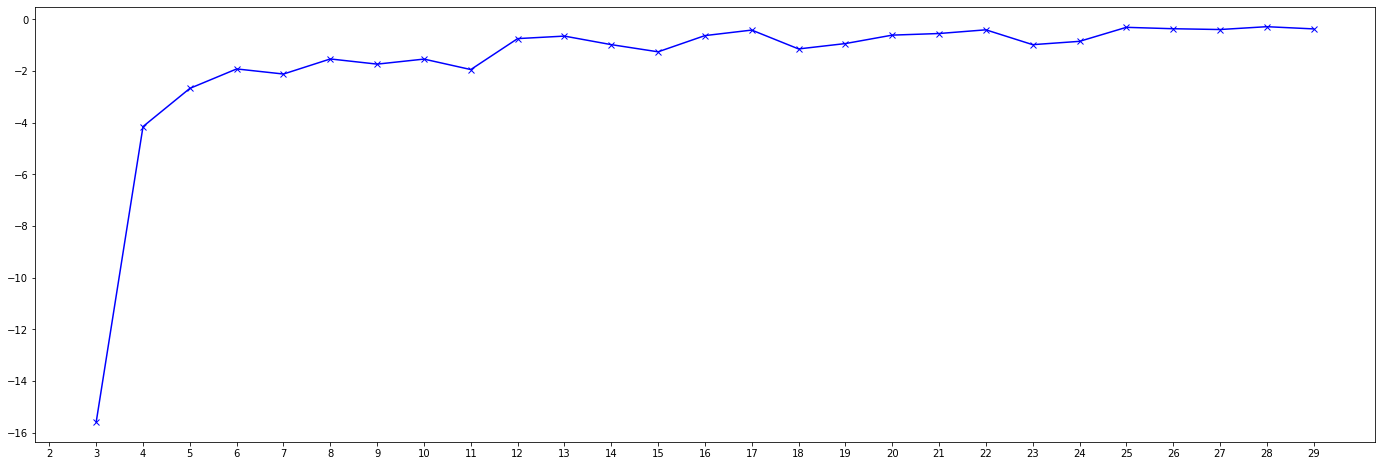

In [29]:
# Adapted from https://worldclass.regis.edu/d2l/le/content/285076/viewContent/4152309/View
# compare the scree plot with a np.diff() plot

plt.figure(figsize=(24,8))
plt.xticks(range(2, 30))
plt.plot(range(3, 30), np.diff(sum_sq), 'bx-')

I am choosing the value of eight as our optimal cluster as it is the first instance of flat slope on the diff chart and is a candidate for an elbow location.

In [30]:
# Adapted from https://worldclass.regis.edu/d2l/le/content/285076/viewContent/4152309/View
# kmeans model with the optimal number of clusters, 8 clusters seems to be our first consistent elbow
model = KMeans(n_clusters=8, random_state=42)
model.fit(X)

# gather the predictions
preds= model.predict(X)

In [31]:
score = silhouette_score(X, preds)
score

0.19875116266688844

- **Use PCA to plot the clusters**

It looks like our first attempt has given us a silhouette score of 0.182. Let's move onto visualizing our clusters and see if we can find a better way of clustering our dataset.

Text(0.5, 1.0, 'Projection of the clustering on a the axis of the PCA')

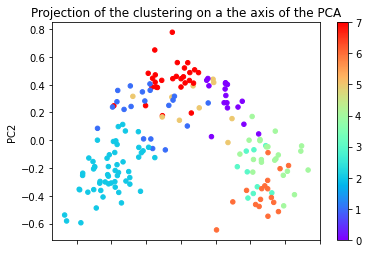

In [32]:
# Adapted from https://worldclass.regis.edu/d2l/le/content/285076/viewContent/4152309/View
pca = PCA(n_components=8)
data_reduced = pca.fit_transform(X)
data_reduced = pd.DataFrame(data_reduced)

ax1 = data_reduced.plot(kind='scatter', x=0, y=1, c=preds, cmap='rainbow')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('Projection of the clustering on a the axis of the PCA')

Our clusters appear to be a bit strange and not very balanced. From here we should try and use

In [33]:
# Adapted from https://worldclass.regis.edu/d2l/le/content/285076/viewContent/4152309/View
# fit the model for clusters and add to sum_sq[]
for n in range (2,20):
    # random_state makes the results reproducible 
    model = KMeans(n_clusters=n, random_state=42)
    model.fit(X)
    
    # gather the predictions
    preds= model.predict(X)
    score = silhouette_score(X, preds)
    print('Silhouette score for ',n,' clusters: ',score)

Silhouette score for  2  clusters:  0.2987221815974774
Silhouette score for  3  clusters:  0.3013463273503232
Silhouette score for  4  clusters:  0.25975014122369366
Silhouette score for  5  clusters:  0.2444646801406278
Silhouette score for  6  clusters:  0.20918564119634217
Silhouette score for  7  clusters:  0.20248019017533464
Silhouette score for  8  clusters:  0.19875116266688844
Silhouette score for  9  clusters:  0.20573123301631233
Silhouette score for  10  clusters:  0.14707766464333102
Silhouette score for  11  clusters:  0.15501419792037613
Silhouette score for  12  clusters:  0.14616493621086984
Silhouette score for  13  clusters:  0.14112323104211916
Silhouette score for  14  clusters:  0.14460560069915127
Silhouette score for  15  clusters:  0.14199503182399223
Silhouette score for  16  clusters:  0.1401363800305377
Silhouette score for  17  clusters:  0.11377773580929697
Silhouette score for  18  clusters:  0.13152101373687916
Silhouette score for  19  clusters:  0.1376

In [34]:
# Adapted from https://worldclass.regis.edu/d2l/le/content/285076/viewContent/4152309/View
# kmeans model with the optimal number of clusters, 2 clusters
model = KMeans(n_clusters=3, random_state=42)
model.fit(X)

# gather the predictions
preds= model.predict(X)

score = silhouette_score(X, preds)
score

0.3013463273503232

Text(0.5, 1.0, 'Projection of the clustering on a the axis of the PCA')

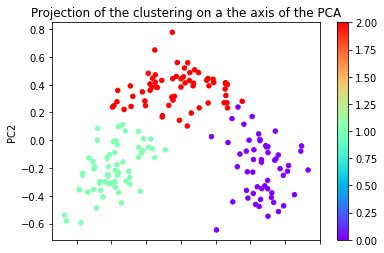

In [35]:
# Adapted from https://worldclass.regis.edu/d2l/le/content/285076/viewContent/4152309/View
# visualize the clusters
pca2 = PCA(n_components=3)
data_reduced2 = pca2.fit_transform(X)
data_reduced2 = pd.DataFrame(data_reduced2)

ax2 = data_reduced2.plot(kind='scatter', x=0, y=1, c=preds, cmap='rainbow')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_title('Projection of the clustering on a the axis of the PCA')

This looks to be our best clustering using KMeans and PCA. We ended up with three distinct clusters for our dataset. From here I am going to do a little bit of analysis comparing our class_id that we had dropped earlier because it had three distinct classes and I want to know how close they are to our output.

In [36]:
preds

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 2, 2, 2, 2,
       2, 2, 0, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int32)

In [37]:
y

0      1
1      1
2      1
3      1
4      1
      ..
173    3
174    3
175    3
176    3
177    3
Name: class_id, Length: 178, dtype: int64

In [38]:
df = pd.DataFrame(data=y)
df['pred_id'] = preds
df

,class_id,pred_id
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
173,3,0
174,3,0
175,3,0
176,3,0


Niavely, from here we could try mapping our pred_id 1 to class_id 1, and so on to 3 and 0. It will not change anything, so I will leave it. I am more interested in the amount of overlap our class_id's have to the pred_id's.

array([[<AxesSubplot:title={'center':'class_id'}>,
        <AxesSubplot:title={'center':'pred_id'}>]], dtype=object)

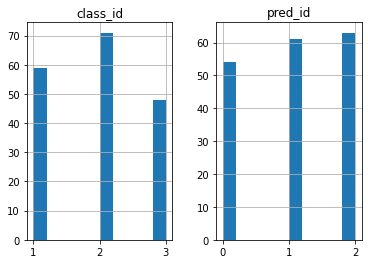

In [39]:
df.hist()

That is really interesting, when we look at it like this we can see that our clusters contain very similar amounts of observations. Let's take a look at how much they overlap with eachother.

In [107]:
one_one = np.where((df['class_id'] == 1) & (df['pred_id'] == 1))[0]
one_not = np.where((df['class_id'] == 1) & (df['pred_id'] != 1))[0]

two_two = np.where((df['class_id'] == 2) & (df['pred_id'] == 2))[0]
two_not = np.where((df['class_id'] == 2) & (df['pred_id'] != 2))[0]

three_zero = np.where((df['class_id'] == 3) & (df['pred_id'] == 0))[0]
three_not = np.where((df['class_id'] == 3) & (df['pred_id'] != 0))[0]

In [94]:
same = len(one_one) + len(two_two) + len(three_zero)
same

170

In [95]:
different = len(one_not) + len(two_not) + len(three_not)
different

8

In [111]:
len(np.where(df['pred_id'] == 1)[0]) - len(one_one)

2

In [110]:
len(np.where(df['pred_id'] == 0)[0]) - len(three_zero)

6

Of our eight differences we had 2 clustered with the ones, and six clustered with the threes. If we go back to our PCA graph we can see that boundary between cluster 2 and cluster 3 are much closer than those for 1 and 2 so the reclustering on those boundaries makes sense.

In [97]:
same / y.shape[0] * 100

95.50561797752809

It appears that all but eight of our classifications wound up with the same grouping as was originally part of the dataset. This means that our methodology ended up with clusters that were composed of 95.5% the same observations. I wonder if I used a different normalization strategy, or a different clustering algorithm if I can reproduce the given clusters precisely.

## V. Conclusion

From the above analysis we can conclude that our KMeans Clustering algorithm has an elbow (optimal K-value) around 8 clusters. When looking at how those eight clusters map using PCA we can not see clear clusters being formed, and the silhouette score confirms this with a score of just 0.198. When looking for the best silhouette score iterating through our KMeans Clustering algorithm again we find our best score at a cluster number of three. Three clusters gave us a score of 0.301 and when analyzed graphically showed a clear clustering that made sense.

When looking at our clusters and comparing them to the class_id's we had dropped from earlier in our analysis I decided that I wanted to see how similarly we ended up clustering the dataset. Once determining a mapping from our encoded clusters to the class_id's we found that 170 of 178 observations ended up in their same cluster. That means that 95.5% of our records class_id's would have been unchanged.

## VI. References

MSDS 650 - Week 6 Content:


1.) __[From the Experts: Text Mining](https://worldclass.regis.edu/d2l/le/content/285076/viewContent/4152314/View)__

2.) __[Week 6: Unsupervised Learning](https://worldclass.regis.edu/d2l/le/content/285076/viewContent/4152309/View)__

3.) __[Week 6 Assignment](https://worldclass.regis.edu/d2l/le/content/285076/viewContent/4152307/View)__

4.) __[Wine Dataset](https://archive.ics.uci.edu/ml/datasets/wine)__